In [1]:
from google.colab import files
uploaded = files.upload()


Saving PlantVillage.zip to PlantVillage.zip


In [2]:
!unzip PlantVillage.zip

Archive:  PlantVillage.zip
   creating: PlantVillage/
   creating: PlantVillage/Potato___Early_blight/
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: PlantVillage

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE =256
BATCH_SIZE =32
CHANNELS =3
EPOCHS = 50

In [5]:
# creating a pipline for my dataset  using TensorFlow's image_dataset_from_directory function
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
## btw the labels for the images are based on the folder names , that's how images are categorized .. so basically the folder names are the class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

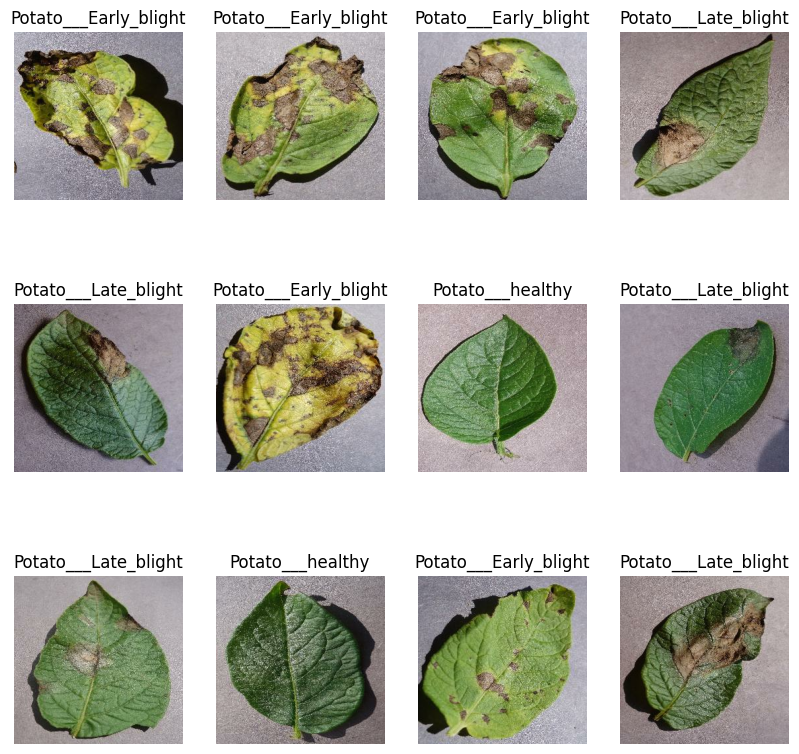

In [8]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    # Loop through a single batch of the dataset.
    # `dataset.take(1)` takes only the first batch from the dataset.
    # `image_batch` contains the images, and `label_batch` contains their corresponding labels.

    for i in range(12):  # Loop through the first 12 images in the batch
        ax = plt.subplot(3, 4, i+1)  # Create a 3x4 grid of subplots
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
        plt.title(class_names[label_batch[i]])  # Set the title based on the label
        plt.axis("off")  # Hide the axis


In [9]:
# Splitting the dataset into training, validation, and test sets:
# - 80% of the data is used for training the model.
# - 10% of the data is used for validating the model during training (hyperparameter tuning, early stopping).
# - 10% of the data is reserved for testing the model after training to evaluate its performance on unseen data.

In [10]:
# Calculate the number of training samples (80% of the dataset)
train_size = 0.8
len(dataset) * train_size  # Number of samples for training

54.400000000000006

In [11]:
# Skip the first 54 batches (already used for training) and use the remaining data for testing and validation
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
# Calculate the number of samples for the validation set (10% of the total dataset)
val_size = 0.1
len(dataset) * val_size  # Number of samples for validation


6.800000000000001

In [13]:
## for our test data set
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split =0.8, val_split =0.1, test_split =0.1, shuffle =True,  shuffle_size =10000):
    # Get the total size of the dataset
    ds_size =len(ds)
     # Shuffle the dataset if the 'shuffle' parameter is set to True
    if shuffle:
        ds =ds.shuffle(shuffle_size, seed =12) # Randomize the dataset with a buffer size

    # Calculate the number of samples for each split (train, validation, and test)
    train_size = int(train_split *ds_size) # Number of samples for training
    val_size = int(val_split * ds_size) # Number of samples for validation

    # Create the training dataset by taking the first 'train_size' samples
    train_ds =ds.take(train_size)
    # Create the validation dataset by skipping 'train_size' samples and taking 'val_size' samples
    val_ds = ds.skip(train_size).take(val_size)
     # Create the test dataset by skipping both 'train_size' and 'val_size' samples
    test_ds = ds.skip(train_size).skip(val_size)
    # Return the partitioned datasets
    return train_ds, val_ds,test_ds


In [15]:
# Call the 'get_dataset_partitions_tf' function to split the dataset into training, validation, and test sets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
# Cache the dataset to improve performance by storing data in memory, then shuffle it with a buffer of 10,000 items,
# and prefetch data to allow parallel loading while training for faster data processing.
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same process applied to the validation dataset: caching, shuffling, and prefetching for efficient data pipeline.
val_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same process applied to the test dataset to ensure efficient loading during evaluation.
test_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
# Create a sequential preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([

   # Resize all images to a fixed size (IMAGE_SIZE x IMAGE_SIZE)
   tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),

   # Rescale pixel values from [0, 255] to [0, 1] by dividing by 255
   tf.keras.layers.Rescaling(1.0/255)
])



In [22]:
#Data argumattion

data_augmentation = tf.keras.Sequential([
   # Randomly flip the images horizontally
   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
   # Randomly rotate images by up to 40 degrees
   tf.keras.layers.RandomRotation(0.2),
   # Randomly zoom into images by a factor of 0.2
   tf.keras.layers.RandomZoom(0.2),
   # Randomly change the brightness of the images
   tf.keras.layers.RandomBrightness(0.2)
])


#BUILD CNN AND TRAIN THIS NETWORK ON THE TRAIN DATASET AFTER WE HAVE DONE LOADING AND SOME PRE-PROCESSING UP

In [23]:

from keras import layers, models

# Input shape
input_shapes = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Batch size is not specified here
n_classes = 3

# Define the model
model = models.Sequential([
    layers.Input(shape=input_shapes),  # First layer is the Input layer that defines the input shape
    resize_and_rescale,  # Your resizing and rescaling layer
    data_augmentation,   # Your data augmentation layer
    layers.Conv2D(32, (3, 3), activation='relu'),  # Conv2D layer without input_shape argument
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # Flatten the output for the Dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Output layer
])

# Build the model
model.build(input_shape=(None,) + input_shapes)  # None for batch size


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size =BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.4603 - loss: 1.3298 - val_accuracy: 0.4728 - val_loss: 0.9848
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.4615 - loss: 0.9387 - val_accuracy: 0.4618 - val_loss: 0.9059
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4429 - loss: 0.9167 - val_accuracy: 0.4716 - val_loss: 0.9140
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4549 - loss: 0.8944 - val_accuracy: 0.4716 - val_loss: 0.9028
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4557 - loss: 0.9049 - val_accuracy: 0.4578 - val_loss: 0.9015
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.4541 - loss: 0.9168 - val_accuracy: 0.4716 - val_loss: 0.8997
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.4524 - loss: 0.8935 - val_accuracy: 0.4716 - val_loss: 0.9026
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.4455 - loss: 0.9053 - val_accuracy: 0.4716 - 

In [27]:
scores =model.evaluate(test_ds)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4899 - loss: 0.8894


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

loss =history.history['loss']
val_loss =history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Acuracy')

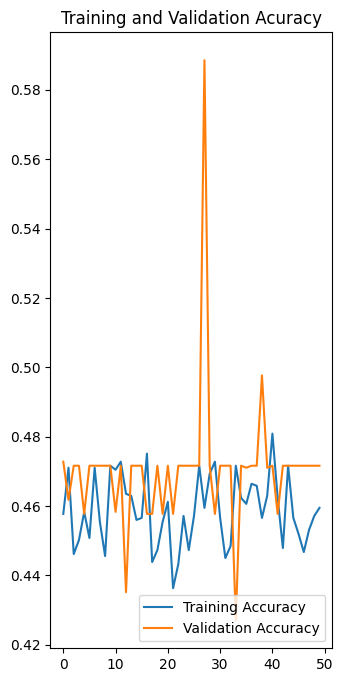

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label= 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Acuracy')

first image to predict
first image's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
predict label: Potato___Early_blight


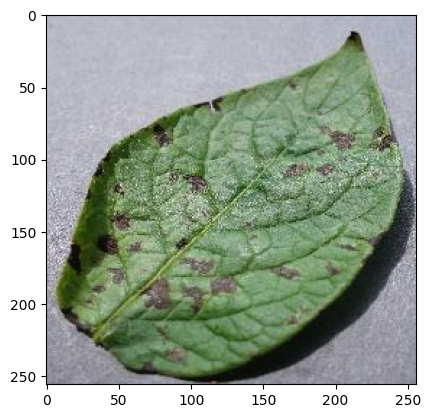

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the first image in the first batch
for images_batch, labels_batch in test_ds.take(1):
    first_image=(images_batch[0].numpy().astype('uint8'))
    first_label =labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction =  model.predict(images_batch)
    print("predict label:",class_names[np.argmax(batch_prediction[0])])


In [46]:
import os

import os

# Define the version number
version = "v1"

# Specify the directory where the model will be saved
model_directory = f"/content/potato_prediction"

# Create the directory if it does not exist
os.makedirs(model_directory, exist_ok=True)

# Specify the full path for saving the model as a .keras file
model_path = os.path.join(model_directory, f"{version}_model.keras")

# Save the model in Keras format
model.save(model_path)

print(f"Model saved at {model_path}")






Model saved at /content/potato_prediction/v1_model.keras


In [34]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array =tf.expand_dims(img_array,0)

  predictions =model.predict(img_array)

  predicted_class =class_names[np.argmax(predictions[0])]
  confidence = round(100 *(np.max(predictions[0])),2)
  return predicted_class, confidence

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Actual_class, predicted_class, and confidence
        actual_class = class_names[labels[i].numpy()]
        predicted_class, confidence = predict(model, images[i])

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")


NameError: name 'test_ds' is not defined

<Figure size 1500x1500 with 0 Axes>